# 기계학습을 이용한 다층구조물에서의 소음원 위치/종류 탐지

* 머신러닝을 활용하여 30종류의 위치&소음원 조합의 50개씩의 데이터 총 1500개의 DataSet을 구별하는 Classifier 모델을 학습하였다.
* 선택한 알고리즘은 Support Vector Machine 과 3 layer Nerual Net 이다
* 해당 코드는 클라우드 기반으로 구글 Colab과 Drive를 사용하였다

In [0]:
from google.colab import drive
drive.mount('/content/drive')

* 구글 코랩에 연결한다

In [0]:
import librosa
import IPython.display
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from sklearn import linear_model
import glob
from tqdm import tqdm
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [3]:
filelist=sorted(glob.glob('/content/drive/My Drive/sound_files/*.m4a'))
print("파일개수 ",len(filelist))

파일개수  1500


* 구글 드라이브에서 전체 음원 파일 위치 목록을 불러온다

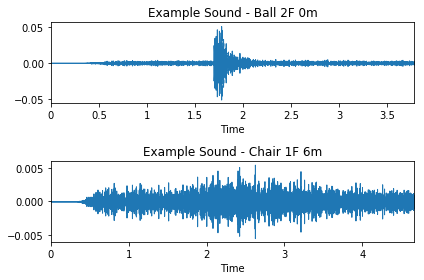

In [4]:
y1, sr=librosa.load(filelist[10])
y2, sr=librosa.load(filelist[1000])

plt.figure()
plt.subplot(2, 1, 1)
librosa.display.waveplot(y1, sr=sr)
plt.title('Example Sound - Ball 2F 0m')
plt.subplot(2,1,2)
librosa.display.waveplot(y2, sr=sr)
plt.title('Example Sound - Chair 1F 6m')
plt.tight_layout()
plt.show()


* 음원파일을 열어본다
* 여기서는 공과 의자 소리의 차이를 보여준다

In [5]:
mfcc_whole=[]
for each_path in tqdm(filelist):
  tx, sr=librosa.load(each_path)
  mfcc=librosa.feature.mfcc(y=tx, sr=sr)
  av_feat=[]
  for each_feat in mfcc:
    av_feat.append(sum(each_feat)/len(each_feat))
  mfcc_whole.append(av_feat)
  

100%|██████████| 1500/1500 [14:54<00:00,  1.61it/s]


* Librosa 라이브러리를 활용하여 각 음원으로 부터 MFCC 특징을 뽑아낸다.
* MFCC는 음원의 길이에 따라 여러 프레임으로 나오는데 여기서는 간단하게 각 MFCC 번호별로 평균을 내었다

In [51]:
df=pd.DataFrame(mfcc_whole)
df2=df.copy()
df2[20]=[z for z in range(1,31) for i in range(0,50)]
df2.head()
df2.to_csv('mfcc_data_labeled.csv',header=False, index=False)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-536.540363,110.273118,-5.743141,18.799755,5.809343,7.707359,-1.055704,5.705636,-1.625086,2.138096,-0.869907,-0.064597,-3.994251,1.217057,-4.303000,1.187887,-1.971259,1.128578,0.155297,6.557962,1
1,-537.948128,111.090251,-5.186216,18.530018,7.549994,7.361076,-0.939301,5.943355,-2.675104,1.800087,-0.206699,-0.092328,-3.706040,2.308623,-3.975322,1.870684,-1.667897,1.478317,-0.395200,5.616403,1
2,-533.790367,110.313222,-4.146904,19.937901,7.451876,8.234901,-0.987362,6.089535,-2.694170,1.803838,-0.587081,0.462991,-2.857767,3.019549,-3.313786,1.820412,-1.165917,1.925983,-0.681735,6.111718,1
3,-538.865751,110.360763,-4.502332,20.620372,8.205115,7.440056,-0.565732,5.893299,-2.594113,1.361902,-0.100339,0.554768,-3.290225,2.146701,-4.143006,1.794328,-0.517079,2.119874,-0.154828,6.278166,1
4,-539.669963,112.670664,-3.781664,18.850710,7.401434,8.531729,-0.591508,5.519034,-2.250008,1.822892,0.289245,1.431900,-3.360705,2.617851,-4.145576,1.107910,-1.619508,2.375885,0.054577,6.541464,1


* MFCC는 음원을 20개의 Feature로 나타내는 특징 추출 방법이다
* 해당 MFCC를 판다스 데이터프레임으로 변환하고 마지막에 해당 음원의 Label을 달아준다.

In [0]:
from google.colab import files
files.download('mfcc_data_labeled.csv')

* MFCC로 변환된 데이터를 csv 파일로 저장한다
* 이 파일을 다시 구글 드라이브에 올린다

## SVM을 이용한 분류기


* 앞에서 다운받은 CSV 파일을 이용하여 Support Vector Machine 분류기를 학습해보겠다.
* 랜덤 sample을 뽑아서 Trainset:TestSet을 60:40으로 나눈뒤
파라미터 튜닝과 Crossvalidation을 Gridsearchcv로 하고 모델을 학습하였다.
* 그후 해당 분류기에 TestSet을 돌려보아 성능을 평가하였다.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 앞에서 저장한 csv 파일을 구글 드라이브로 옮겨준뒤 불러온다.(학습의 편의성을 위해 csv 파일로 다운 받았다)

In [0]:

df_label_all=pd.read_csv('/content/drive/My Drive/sound_files/mfcc_data_labeled.csv',header=None)
df_label_all=df_label_all.sample(frac=1)

In [0]:
df_train=pd.DataFrame()
df_test=pd.DataFrame()
for i in range(1,31):
  df_train=df_train.append(df_label_all[df_label_all[20]==i].iloc[0:30])
  df_test=df_test.append(df_label_all[df_label_all[20]==i].iloc[30:50])



*   전체 데이터를 랜덤 샘플링 해준뒤 학습셋과 테스트셋을 나눈다. 비율은 학습:테스트 = 60 :40으로 했다



In [0]:
df_train=df_train.sample(frac=1)
df_test=df_test.sample(frac=1)
y_train=df_train[20]
df_train.drop(20,axis=1,inplace=True)
y_test=df_test[20]
df_test.drop(20, axis=1, inplace=True)



* label값을 분리하여 y_train, y_test에 넣어준다

In [0]:
df_train=StandardScaler().fit_transform(df_train)
df_test=StandardScaler().fit_transform(df_test)

* MFCC 특징값들을 정규화 시켜준다

In [29]:
mdl=svm.SVC(gamma='auto')
mdl.fit(df_train,y_train)
predict=mdl.predict(df_test)
print("Baseline accuracy : ", accuracy_score(y_test,predict))

Baseline accuracy :  0.91


* 서포트벡터 머신 모델을 작성한다
* 가장 기초적인 모델인 SVC를 하였고 커널은 기본값인 'rbf'를 사용한다
* Train set과 Test set을 각각 학습과 테스트에 사용하여 Baseline 점수를 얻었다

In [37]:
mdl2=svm.SVC(gamma='auto')
parameters = {'C':[1,5, 10,50,100,150,160,180,200,250,300,500]}
clf = GridSearchCV(mdl2, parameters, cv=5)
clf.fit(df_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10, 50, 100, 150, 160, 180, 200, 250, 300,
                               500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

* 보다 정확한 모델과 파라미터 튜닝을 위해 GridSearch를 사용한다
* Crossvalidation은 5로 하고 SVC에서 마진의 폭에 영향을 주는 'C'값을 다양하게 넣고 실행한다

In [38]:
print("accuracy with GridSearch, Crossvalidation : ",clf.best_score_)
print("Best estimator, parameters")
clf.best_estimator_

accuracy with GridSearch, Crossvalidation :  0.9455555555555556
Best estimator, parameters


SVC(C=250, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

* 그리드 서치의 결과는 좋은 결과가 나왔다.
* C값은 250이 가장 좋게 나왔다
* GridSerachCV는 최적 파라미터를 구한뒤 이것을 다시 전체 train set으로 Refit하는 기능을 가지고 있어 최적 estimator를 구해준다
* 이 estimator에 아까 나누어 놓았던 test set을 돌려서 최종 평가를 받는다.

In [39]:
predic=clf.predict(df_test)
print("Testset results")
print(classification_report(y_test,predic))

Testset results
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       0.91      1.00      0.95        20
           3       0.90      0.90      0.90        20
           4       1.00      0.80      0.89        20
           5       0.82      0.90      0.86        20
           6       0.91      1.00      0.95        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      0.90      0.95        20
          11       1.00      0.95      0.97        20
          12       0.95      0.95      0.95        20
          13       1.00      0.95      0.97        20
          14       1.00      1.00      1.00        20
          15       0.90      0.90      0.90        20
          16       0.95      1.00      0.98        20
          17       0.87      1.00      0.93        20
          1

* 최종정확도는 0.96으로 그리드서치와 Crossvalidation을 하기 전인 0.91보다 대폭 좋은 성능을 보여주었다.

## Nerual Net 모델을 활용한 분류기 Using Keras

* 이번에는 딥러닝 모델의 기초인 2-Hidden Layer을 가진 신경회로망을 이용해 소리를 분류해겠다
* Keras를 활용하여 학습하였다
* 특징값은 앞에서 얻은 20-MFCC를 그대로 사용한다
* 데이터를 학습:Validation : Test Set 으로 각각 1050 : 300 :150 으로 나누어서 사용하였다

In [40]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


* 케라스를 불러온다

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_label_all=pd.read_csv('/content/drive/My Drive/sound_files/mfcc_data_labeled.csv',header=None)
df_label_all=df_label_all.sample(frac=1)

df_train=pd.DataFrame()
df_test=pd.DataFrame()
df_final=pd.DataFrame()
for i in range(1,31):
  df_train=df_train.append(df_label_all[df_label_all[20]==i].iloc[0:35])
  df_test=df_test.append(df_label_all[df_label_all[20]==i].iloc[35:45])
  df_final=df_final.append(df_label_all[df_label_all[20]==i].iloc[45:50])



* 앞서 SVM 모델에서 사용했던 csv 파일을 다시 불러온다

In [0]:
df_train=df_train.sample(frac=1)
df_test=df_test.sample(frac=1)
df_final=df_final.sample(frac=1)
 
y_train=df_train[20]
df_train.drop(20,axis=1,inplace=True)
y_test=df_test[20]
df_test.drop(20, axis=1, inplace=True)

y_final=df_final[20]
df_final.drop(20,axis=1,inplace=True)


* 학습 , validation ,test set으로 나누고 label 열을 분리해준다

In [0]:

df_train=StandardScaler().fit_transform(df_train)
df_test=StandardScaler().fit_transform(df_test)
df_final=StandardScaler().fit_transform(df_final)

* 마찬가지로 정규화 시켜준다

In [0]:

y_train=y_train-1
y_test=y_test-1
y_final=y_final-1

one_hot_train=to_categorical(y_train)
one_hot_test=to_categorical(y_test)
one_hot_final=to_categorical(y_final)

* 30개의 레이블을 one-hot encoding 시켜준다

In [46]:
model=models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(20,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(30,activation='softmax'))

* 30개의 레이블이므로 넉넉하게 중간층 2개, 각각 64개의 유닛으로 설계하였다
* 마지막은 30개의 유닛으로 softmax로 다중 레이블 분류기로 만들었다
* 은닉층을 3개, 유닛을 128개로 해보았으나 크게 향상되는 부분이 없어 가볍게 모델을 설계했다

In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

* 모델을 컴파일한다. optimizer는 최근에 널리쓰이는 아담을 사용한다
* 이때 Earlystopping을 patience 10으로 두어 불필요하게 학습이 길어지고 오버피팅이 발생하는 을 피한다

In [48]:
early_stopping = EarlyStopping(monitor='val_acc',patience=10)

history=model.fit(df_train,one_hot_train,epochs=100,batch_size=16,validation_data=(df_test,one_hot_test),callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1050 samples, validate on 300 samples
Epoch 1/100
1050/1050 [==============================] - 1s 780us/step - loss: 2.9002 - acc: 0.2333 - val_loss: 2.2797 - val_acc: 0.4700
Epoch 2/100
1050/1050 [==============================] - 0s 84us/step - loss: 1.8029 - acc: 0.5743 - val_loss: 1.3578 - val_acc: 0.6767
Epoch 3/100
1050/1050 [==============================] - 0s 82us/step - loss: 1.1389 - acc: 0.7200 - val_loss: 0.9360 - val_acc: 0.7500
Epoch 4/100
1050/1050 [==============================] - 0s 85us/step - loss: 0.8211 - acc: 0.7876 - val_loss: 0.7371 - val_acc: 0.7700
Epoch 5/100
1050/1050 [==============================] - 0s 84us/step - loss: 0.6351 - acc: 0.8314 - val_loss: 0.5964 - val_acc: 0.8133
Epoch 6/100
1050/1050 [==============================] - 0s 89us/step - loss: 0.5023 - acc: 0.8657 - val_loss: 0.5187 - val_acc: 0.8400
Epoch 7/100
1050/1050 [==================

* 학습 결과를 보면 대략 0.95에서 움직이는 것을 볼 수 있다. 이것은 앞서 SVM에서의 0.96과 유사한 결과이다.

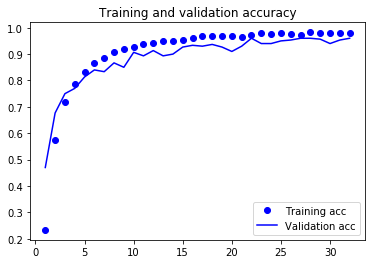

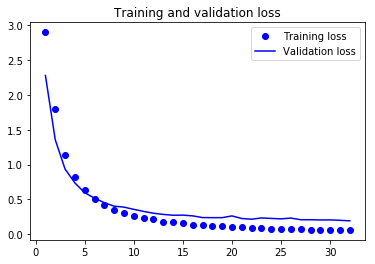

In [49]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
loss_and_metrics = model.evaluate(df_final, one_hot_final, batch_size=16)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

150/150 [==============================] - 0s 127us/step
## evaluation loss and_metrics ##
[0.13251297666380804, 0.9333333333333333]


* 최종적으로 학습된 모델에 Test set을 넣어 성능을 평가해본다
* 0.93~0.96에서 진동한다.
* svm과 유사한 성능을 보여준다

## 결론

* 30개의 label을 가진 1500개의 오디오 데이터를 분류하는 support vecter classifier와 Nerual Net을 생성해보았다.
* 소리의 특징들이 소리의 종류마다 크게다르고 층별로는 진폭의 크기가 크게 다르기 때문에 간단한 머신러닝 알고리즘으로도 높은 성능을 보여주었다.
* SVM의 경우 Gridserachcv를 통해 최적의 파라미터를 튜닝하여 baseline보다 높은 성능 ( 0.91-> 0.96)을 얻어낼 수 있었다
* Nerural Net의 경우 빠르게 accuracy가 수렴하였고 결과적으로 SVM의 결과와 모델 성능이 비슷하였다.